In [1]:
# required modules (under Anaconda use: > conda install -c conda-forge <package>)
if False: # (skip if already installed)
    !pip install lark-parser
    !pip install linear-tree
    !pip install pydot
    !pip install pydotplus
    # download and install SWI Prolog from https://www.swi-prolog.org/download/stable
    # be sure that the executable is added to the PATH

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# standard imports
import sys
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# local imports
sys.path.append('../src/') # local path
import reasonx
import dautils

### Set dataframe

In [3]:
# Generate 100 random values for x from a normal distribution
random.seed(40)
t1 = np.round(np.random.uniform(-50, 100, 1000)).astype(int)
t2 = np.round(np.random.uniform(0, 180, 1000)).astype(int)
t = t1+t2

# Apply the condition: c = 0 if x <= 0 or x >= 100, else y = 1
y = np.where( np.logical_or(t <= 0, t >= 100), 0, 1)

# Create the DataFrame
df = pd.DataFrame({'t1': t1, 't2': t2, 't': t, 'y': y})
pred_atts = ['t1', 't2', 't']
target = 'y'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   t1      1000 non-null   int64
 1   t2      1000 non-null   int64
 2   t       1000 non-null   int64
 3   y       1000 non-null   int64
dtypes: int64(4)
memory usage: 31.4 KB


In [4]:
# df 
df

,t1,t2,t,y
0,47,94,141,0
1,81,107,188,0
2,24,20,44,1
3,44,52,96,1
4,80,99,179,0
...,...,...,...,...
995,88,54,142,0
996,-38,45,7,1
997,-15,152,137,0
998,2,170,172,0


### Build global decision tree

In [5]:
# split predictive and target
X, y = df[pred_atts], df[target]
# train a decision tree
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

DecisionTreeClassifier(max_depth=3)

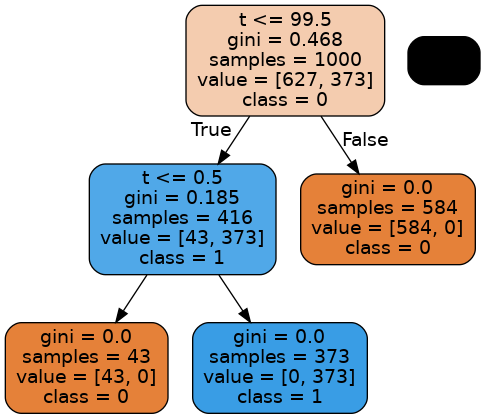

In [6]:
from sklearn import tree
import pydotplus
from IPython.display import Image

# visualize the decision tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                    feature_names=pred_atts, # attributes names
                    class_names=["0", "1"], # class labels
                    filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

### Explain tree with ReasonX

In [7]:
# DT embedding
df_code = dautils.Encode(nominal=[], ordinal=[target], decode={}, onehot=True, prefix_sep="_")
df_code.fit_transform(df)
r = reasonx.ReasonX(pred_atts, target, df_code, verbose=2) # verbose=2 high verbosity
r.model(clf)

In [8]:
# factual rule on an instance
r.instance('F', label=1)
r.constraint("F.t1 = -10, F.t2 = 20")
r.solveopt()

---
Answer constraint: F.t1= -10.0,F.t2=20.0,F.t>0.5,F.t<=99.5
Rule satisfied by F: IF F.t>0.5,F.t<=99.5 THEN 1 [1.0000]


In [9]:
# set user constraints
r.reset(keep_model=True)
r.instance('F', label=1)
r.constraint("F.t=F.t1+F.t2, F.t1 = -10")
r.verbosity(2)  # low verbosity
r.solveopt()

---
Answer constraint: F.t1= -10.0,F.t2>10.5,F.t2<=109.5,F.t= -10.0+F.t2
Rule satisfied by F: IF F.t>0.5,F.t<=99.5 THEN 1 [1.0000]


In [10]:
# set user constraints
r.reset(keep_model=True)
r.instance('F', label=1)
r.constraint("F.t=F.t1+F.t2, F.t1 >= -15, F.t1 <= -5")
r.verbosity(2)  # low verbosity
r.solveopt()

---
Answer constraint: F.t1>= -15.0,F.t1<= -5.0,F.t2= -F.t1+F.t,F.t>0.5,F.t<=99.5
Rule satisfied by F: IF F.t>0.5,F.t<=99.5 THEN 1 [1.0000]


In [11]:
r.solveopt(project=["F.t1","F.t2"])

---
Answer constraint: F.t1>= -15.0,F.t1<= -5.0,F.t1+F.t2>0.5,F.t1+F.t2<=99.5
Rule satisfied by F: IF  THEN 1 [1.0000]


In [12]:
r.solveopt(project=["F.t2"])

---
Answer constraint: F.t2>5.5,F.t2<=114.5
Rule satisfied by F: IF  THEN 1 [1.0000]


In [13]:
# counter-factual rules with min conf
r.instance('CF', label=1-y.iloc[0], minconf=0.8)
r.constraint("CF.t=CF.t1+CF.t2, CF.t1=F.t1")
r.solveopt(project=["CF.t1","CF.t2", "F.t1", "F.t2"])

---
Answer constraint: CF.t1=F.t1,F.t1+CF.t2>0.5,F.t1+CF.t2<=99.5,F.t1>= -15.0,F.t1<= -5.0,F.t1+F.t2>0.5,F.t1+F.t2<=99.5
Rule satisfied by F: IF  THEN 1 [1.0000]
Rule satisfied by CF: IF  THEN 1 [1.0000]


In [14]:
r.solveopt(minimize='l1norm(F, CF)')

---
Answer constraint: F.t>=0.5,F.t<=99.5,CF.t=F.t,F.t2= -F.t1+F.t,CF.t2= -F.t1+F.t,F.t1>= -15.0,F.t1<= -5.0,CF.t1=F.t1
Min value: 0.0
Rule satisfied by F: IF F.t>0.5,F.t<=99.5 THEN 1 [1.0000]
Rule satisfied by CF: IF CF.t>0.5,CF.t<=99.5 THEN 1 [1.0000]
